In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import KernelPCA
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report
from collections import Counter
%matplotlib inline

### Reading in the *'colonTumor.data'* file and checking the dimensions:

In [2]:
data = pd.read_csv('colonTumor.data', header=None)
print data.shape

(62, 2001)


### Observations:
- The number of features is far greater than the number of samples.
- Almost any ML algorithm will overfit the dataset very easily.

### Inference:
- There might be a need for either feature selection or feature decomposition.
- Cross validation would be the ideal way to evaluate a model's performance for the given dataset.

### Indexing columns from 1 and renaming the targets as *'label'*

In [3]:
cols = list(data.columns+1)
cols.remove(2001)
cols.append('label')
data.columns = cols
data.head()

,1,2,3,4,5,6,7,8,9,10,...,1992,1993,1994,1995,1996,1997,1998,1999,2000,label
0,8589.4163,5468.2409,4263.4075,4064.9357,1997.8929,5282.3250,2169.7200,2773.4212,7526.3862,4607.6762,...,67.56125,259.91250,138.89875,88.23250,39.667857,67.82875,75.67750,83.52250,28.70125,negative
1,9164.2537,6719.5295,4883.4487,3718.1589,2015.2214,5569.9071,3849.0588,2793.3875,7017.7338,4802.2524,...,92.23875,96.27625,150.59000,82.23750,85.033333,152.19500,186.56750,44.47250,16.77375,positive
2,3825.7050,6970.3614,5369.9688,4705.6500,1166.5536,1572.1679,1325.4025,1472.2587,3296.9512,2786.5821,...,82.71500,31.10250,193.92000,76.97250,224.620240,31.22500,42.65625,16.09250,15.15625,negative
3,6246.4487,7823.5341,5955.8350,3975.5643,2002.6131,2130.5429,1531.1425,1714.6312,3869.7850,4989.4071,...,41.68375,5.92500,183.00625,74.52875,67.710714,48.33875,42.52000,49.98250,16.08500,positive
4,3230.3287,3694.4500,3400.7400,3463.5857,2181.4202,2922.7821,2069.2463,2948.5750,3303.3712,3109.4131,...,76.60375,161.35000,61.70125,54.56375,223.359520,73.09875,57.59875,7.48875,31.81250,negative


### Checking for class imbalance:

In [4]:
print Counter(data['label'])

Counter({'negative': 40, 'positive': 22})


### Deductions:
- We have roughly a 65-35 % split between 'positive' and 'negative' samples.
- Accuracy will be a skewed metric for the dataset, a better alternative is **precision**.

### Checking for structure in the data by visualisation:
- Applying PCA with a *cosine* kernel on the 2000 features and decomposing down to two features.
- Using the two features to plot the data using a scatter plot.

**Note: The *'cosine'* kernel was selected via trial and error**.

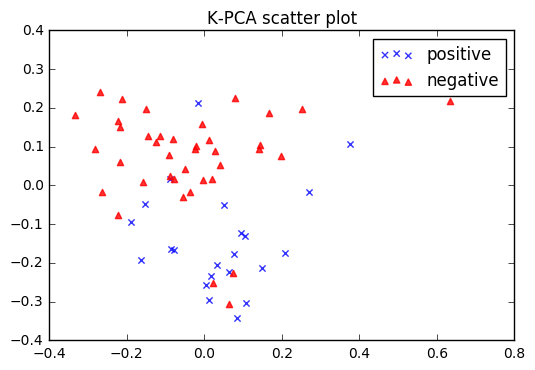

In [5]:
model = KernelPCA(n_components=2, kernel='cosine', gamma=10)
decomposed_data = model.fit_transform(data.drop(['label'], axis=1))
plt.figure()
plt.scatter(decomposed_data[np.where(data['label'] == 'positive'), 0],
            decomposed_data[np.where(data['label'] == 'positive'), 1],
        marker='x', color='b',
        alpha=0.8, label='positive')
plt.scatter(decomposed_data[np.where(data['label'] == 'negative'), 0],
            decomposed_data[np.where(data['label'] == 'negative'), 1],
        marker='^', color='r',
        alpha=0.8, label='negative')
plt.legend(loc='best')
plt.title('K-PCA scatter plot')
plt.show()

### Observations:
- There is definitely a visible structure in the data.
- There are clearly some outliers in the data when projected in 2D.

### Inference:
- Feature decompostion will work well for the dataset.
- There is no clean way to identify the outliers, better to keep them for now since data is already scarce and they might not be real outliers in a hyperspace.

# Model Building

### Decomposing dataset:
- Using Kernel PCA to decompose the dataset into 4 features.

**Note: n_components=4 was found to be optimal via manual search**.

In [6]:
kernel = KernelPCA(n_components=4, kernel='cosine')
decomposed_data = kernel.fit_transform(data.drop(['label'], axis=1))

### Classification and validation:

- Since the dataset has only 62 samples, 'Leave one out' cross validation was chosen.
- This is the best estimation of the out of sample performance that we can get.
- The final model that was chosen was a multi-layered perceptron with ReLu units. Sklearn's implentation was used directly to create, train and validate the model.
- Other models that were tried are logistic regression, adaboost, random forest and support vector machine, but MLP gave far superior precision.
- The hyper-parameters were chosen manually.

In [7]:
# Creating a leave-one-out validator.
loocv = LeaveOneOut()

# Creating an MLP with optimal set of hyperparameters.
mlp_model = MLPClassifier(hidden_layer_sizes=(20, 10, 5), activation='relu',
                          alpha=0.01, max_iter=800,tol=0.0001, epsilon=1e-6)

### For each of the 62 splits of the data:

- The MLP is trained with 61 samples.
- The prediction for 1 data point (which is not present in the train set) is obtained.

In [8]:
# Creating empty lists to store the prediction and true label for each split of data.
preds = []
labels = []

# Iterating through all the 62 splits of data.
for train_idx, test_idx in loocv.split(decomposed_data):
    # Training the model with the train set of decomposed features.
    mlp_model.fit(decomposed_data[train_idx, :], data.iloc[train_idx, -1])
    
    # Obtaining prediction for the test data point.
    pred = mlp_model.predict(decomposed_data[test_idx, :])
    
    # Appending prediction and true label to the lists.
    preds.append(pred[0])
    labels.append(data.iloc[test_idx, -1].values[0])


/home/nilabhra/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


### Generating classification report:

In [9]:
# Using the prediction and label lists to generate classification report.
print classification_report(labels, preds)

             precision    recall  f1-score   support

   negative       0.90      0.90      0.90        40
   positive       0.82      0.82      0.82        22

avg / total       0.87      0.87      0.87        62

